In [85]:
#Imported relevant and necessary libraries and data cleaning tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp
import plotly_express as px #plotly express is a library for drawing interactive figures
from glob import glob as lsdir
import os
import re
import datetime as dt

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [86]:
#Code from Professor Manning to set up and read in the relevant UVLT data 
data_readers = {'xlsx': pd.read_excel, 'xls': pd.read_excel, 'dta': pd.read_stata}
get_extension = lambda x: x.split('.')[-1]


def read_data(datadir, readers):
    files = lsdir(os.path.join('..', datadir, '*'))
    readable_files = []
    data = []
    for f in files:
        ext = get_extension(f)
        if ext in readers.keys():
            readable_files.append(f)
            data.append(data_readers[ext](f))
    return readable_files, data


fnames, data = read_data('data', data_readers)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


#### I changed U_Tot_Amt to 'TotalUnrestrictedDonations' to make it easier to work with later on

In [87]:
#Renaming relevant columns in UVLT individual data to be more easily readable
names={'DeceasedDateYN' : 'Is the donor Deceased?',
       'U_Tot_Amt': 'TotalUnrestrictedDonations',
      'U_Tot_Cnt': 'Total # Unrestricted Donations',
      'ConservedOwner' : 'Owns Conserved Land?',
      'RTotAmt' : 'Total Restricted Donations',
       'RTotCnt': 'Total # Restricted Donations',
      'VTotCnt' : 'Total Volunteer Occurances',
      'ETotCnt' : 'Total Event Attendances'}
data[1].rename(names, inplace=True, axis=1)

#copying each set of data into more memorably named versions
final_data=data[1].copy()

### Multi-dimensional view of the data

Here, I used hypertools to plot the data, colored by Town (rows where unrestricted donations were null or 0 were removed). This functions takes multi-dimensional data, plotting it based on the three most important factors. Using this visualization early in the analysis supports the hypothesis that Town is a significant factor on donations. We see this in the way colors group together whereas if Town was insignificant, we would expect to see a random scatter of colors/Town.

/optnfs/el7/jupyterhub/envs/Psych81.09/lib/python3.6/site-packages/hypertools/tools/format_data.py:141: UserWarning:

Missing data: Inexact solution computed with PPCA (see https://github.com/allentran/pca-magic for details)



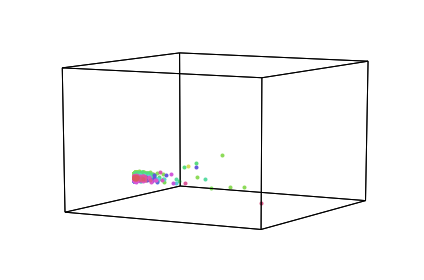

In [89]:
# remove rows where total unrestricted donations is null or zero
udonations = final_data[pd.notnull(final_data['TotalUnrestrictedDonations'])]
udonations = udonations[udonations.TotalUnrestrictedDonations != 0]

# plot 3d view of data, colored by towns
plot = hyp.plot(udonations, '.', hue=udonations.Town)

#### I added "TotUdonations" which is the total donations for a town

In [92]:
#creates new DataFrame of average unrestricted donations -- this will be used to store all averages
avg_data = final_data.groupby('Town', as_index=False)['TotalUnrestrictedDonations'].mean()

#add columns with average town data to the new DataFrame
avg_data['Avg # UR Donations'] = final_data.groupby('Town', as_index=True)['Total # Unrestricted Donations'].mean().values
avg_data['TotUdonations'] = final_data.groupby('Town', as_index=True)['TotalUnrestrictedDonations'].sum().values
avg_data['Avg R Donations'] = final_data.groupby('Town', as_index=True)['Total Restricted Donations'].mean().values
avg_data['Avg # R Donations'] = final_data.groupby('Town', as_index=True)['Total # Restricted Donations'].mean().values
avg_data['Avg Volunteer Occurances'] = final_data.groupby('Town', as_index=True)['Total Volunteer Occurances'].mean().values
avg_data['Avg Event Attendances'] = final_data.groupby('Town', as_index=True)['Total Event Attendances'].mean().values
avg_data.rename({'TotalUnrestrictedDonations' : 'Avg UR Donations'}, inplace=True, axis = 1)

avg_data.drop(avg_data.index[0], inplace=True)

zipcode_data=data[3].copy()
town_data=data[4].copy()

#merge town demographics to main averages DataFrame
avg_data = pd.merge(avg_data, town_data, on="Town")
avg_data.drop(['TownID'], axis=1)

avg_data.head()

,Town,Avg UR Donations,Avg # UR Donations,TotUdonations,Avg R Donations,Avg # R Donations,Avg Volunteer Occurances,Avg Event Attendances,TownID,Nprojects,Nacres,Nmembers,MedianHHIncome,MeanHHIncome,PercBAplus,PercAge55Plus
0,Bath,NaN,NaN,0.00,NaN,NaN,NaN,NaN,1,9,746.00,0,47386,60413,25.274725,48.844538
1,Bradford,45.607143,0.878571,6385.00,407.857143,0.035714,0.164286,0.457143,2,20,2258.32,7,48056,58716,30.600000,32.912306
2,Canaan,90.153541,1.009569,18842.09,3.110048,0.014354,0.272727,0.315789,3,9,1676.35,10,58333,68870,25.300000,33.863520
3,Cavendish,NaN,NaN,0.00,NaN,NaN,NaN,NaN,4,0,0.00,0,48750,69230,31.001727,40.359043
4,Charlestown,22.196262,0.308411,2375.00,5.607477,0.018692,0.093458,0.214953,5,2,408.90,2,42693,50823,14.300000,36.050905


### Creating deciles in the data

I created deciles in the data based on the total amount of unrestricted donations. By using total as opposed to average, we can later determine which towns provide the most significant funding. Average donations are a useful view as well, but total donations in a town may differ significantly from average donations due to outliers (ie. one or two highly significant donors)

In [95]:
# remove rows where total unrestricted donations is null or zero
avg_data = avg_data[pd.notnull(avg_data['TotUdonations'])]
avg_data = avg_data[avg_data.TotUdonations != 0]

# inspired by http://www.datasciencemadesimple.com/quantile-decile-rank-column-pandas-python-2/

# create quintiles based on unrestricted donations
avg_data['decile_ud']=pd.qcut(avg_data['TotUdonations'],10,labels=False)

# create stacked bar plot
pivot_avg_data = avg_data.pivot(index='decile_ud', columns='Town', values='TotUdonations')
pivot_avg_data
                                              
                                               
#inspired by https://pstblog.com/2016/10/04/stacked-charts

Town,Bradford,Canaan,Charlestown,Chelsea,Claremont,Corinth,Cornish,Enfield,Fairlee,Grafton,...,Springfield,Strafford,Thetford,Topsham,Tunbridge,Vershire,Weathersfield,West Windsor,Windsor,Woodstock
decile_ud,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,710.0,NaN,NaN,NaN,NaN,NaN,1690.0,...,NaN,NaN,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2375.0,NaN,4637.0,4700.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3750.0,NaN,NaN,NaN,NaN,NaN
2,6385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8935.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,18842.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19695.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,20405.0,NaN,20828.1,NaN,...,20882.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57936.39,NaN,NaN,...,NaN,69277.24,NaN,NaN,NaN,24770.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,97408.04,NaN,NaN,NaN,NaN,97184.37,NaN,126711.88
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Stacked bar plot based on deciles

By viewing a stacked bar plot of towns and the deciles in which we belong, it is clearly apparent that the majority of donations stems from the top decile, while very small amounts of donations come from towns in lower deciles. It's important to keep in mind that the comparable size of the town will play a role in the total amount of donations, and it is also possible that marketing and events are focused in some towns more than others. 

That being said, by understanding that the majority of donations come from only a few towns, further questions can explored as to whether marketing is warranted or should be increased in smaller towns. It could be the case that costs of soliciting donations in smaller towns outweighs donations that come from those towns, or it could be the case that there exists opportunity in doubling down efforts to smaller towns.

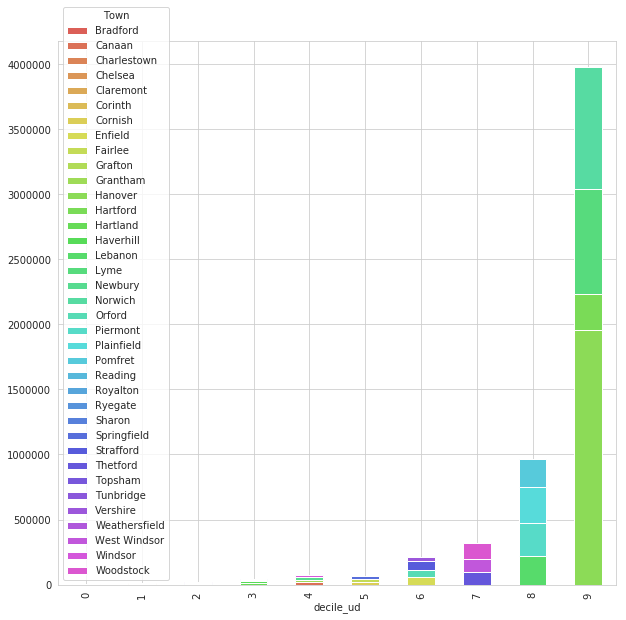

In [97]:
# stacked bar plot 

pivot_avg_data.plot.bar(stacked=True, figsize=(10,10))
